In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity


rentdf= pd.read_csv('./170911_rentclear.csv')
envdf= pd.read_csv('./env_clear.csv')

In [2]:
import pymysql
import redis

#redis connection
#r = redis.StrictRedis(host='172.17.0.2', port=6379, db=0)

#connect maria rdb
db = pymysql.connect(
        host='172.17.0.4',
        user='root',
        passwd='1234',
        db='rental',
        charset='utf8mb4'
    )
#設置cursor
cursor = db.cursor()
cursor.execute('SELECT * FROM typeID;')

22

In [3]:
typeid = dict(cursor.fetchall())

In [4]:
rentdf.head()

,Unnamed: 0,ID,cityID,pet,rent,space,lat,lng,label,floor,unit
0,0,1,251,N,25000,62.34,25.181837,121.440487,住,5,401.026628
1,1,2,251,N,32000,50.70,25.197719,121.421685,住,2,631.163708
2,2,3,251,N,25000,44.97,25.178503,121.454991,住,9,555.926173
3,3,4,251,N,5000,7.00,25.170918,121.441836,套,4,714.285714
4,4,5,239,N,6000,7.99,24.974047,121.327134,套,3,750.938673


In [70]:
envdf.head()

,Unnamed: 0,ID,cityID,typeID,cost,lat,lng
0,0,1,104,101,300,25.056030,121.544220
1,1,2,235,101,150,25.002616,121.472260
2,2,3,241,101,145,25.066205,121.498771
3,3,4,106,101,745,25.026635,121.551803
4,4,5,110,101,64,25.039510,121.576738


In [6]:
typeid

{101: 'Food',
 102: 'Supermarket',
 201: 'Bus',
 202: 'MRT',
 203: 'UBike',
 204: 'Train',
 205: 'Exam',
 206: 'Charger',
 207: 'Towing',
 301: 'BookStore',
 302: 'DepartmentStore',
 303: 'Library',
 304: 'Museum',
 305: 'Theater',
 401: 'Park',
 402: 'Scenic',
 403: 'Sport',
 501: 'School',
 502: 'Hospital',
 503: 'Pharmacy',
 504: 'Police',
 505: 'FireStation'}

In [7]:
from LatLonToTWD97 import LatLonToTWD97
c = LatLonToTWD97()

In [37]:
data = list(map(c.convert,envdf[envdf.typeID==102].loc[:,['lat','lng']].values))

In [40]:
%%time
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.arange(0,500,50)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

best bandwidth: 300
CPU times: user 12min 24s, sys: 569 ms, total: 12min 24s
Wall time: 12min 23s


In [42]:
grid.best_estimator_.bandwidth

300

In [97]:
start_bandwidth = 100
end_bandwidth = 501
step = 50
best = end_bandwidth + 100
data = list(map(c.convert,envdf[envdf.typeID==403].loc[:,['lat','lng']].values))
while True:
    band_range = np.arange(start_bandwidth,end_bandwidth,step)
    params = {'bandwidth': band_range}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(data)
    best = grid.best_estimator_.bandwidth
    end_bandwidth = end_bandwidth + 100
    start_bandwidth = start_bandwidth + 100
    if best < start_bandwidth or end_bandwidth>2100:
        break
    #start_bandwidth = start_bandwidth + 500

In [98]:
end_bandwidth

1901

In [99]:
best

1450

In [43]:
%%time
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

result = {}
for key in typeid.keys():
    start_bandwidth = 100
    end_bandwidth = 501
    step = 100
    best = end_bandwidth + 100
    data = list(map(c.convert,envdf[envdf.typeID==key].loc[:,['lat','lng']].values))
    while best > end_bandwidth:
        band_range = np.arange(start_bandwidth,end_bandwidth,step)
        params = {'bandwidth': band_range}
        grid = GridSearchCV(KernelDensity(), params)
        grid.fit(data)
        best = grid.best_estimator_.bandwidth
        end_bandwidth = end_bandwidth + 100
        #start_bandwidth = start_bandwidth + 500
    result[key] = grid.best_estimator_

CPU times: user 11min 3s, sys: 472 ms, total: 11min 3s
Wall time: 11min 2s


In [44]:
result

{101: KernelDensity(algorithm='auto', atol=0, bandwidth=300, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 102: KernelDensity(algorithm='auto', atol=0, bandwidth=500, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 201: KernelDensity(algorithm='auto', atol=0, bandwidth=500, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 202: KernelDensity(algorithm='auto', atol=0, bandwidth=500, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 203: KernelDensity(algorithm='auto', atol=0, bandwidth=500, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 204: KernelDensity(algorithm='auto', atol=0, bandwidth=500, breadth_first=True,
        kernel='gaussian

In [108]:
%%time
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

result2 = {}
def getbw(key):
    start_bandwidth = 100
    end_bandwidth = 501
    step = 100
    best = end_bandwidth + 100
    data = list(map(c.convert,envdf[envdf.typeID==key].loc[:,['lat','lng']].values))
    while True:
        band_range = np.arange(start_bandwidth,end_bandwidth,step)
        params = {'bandwidth': band_range}
        grid = GridSearchCV(KernelDensity(), params)
        grid.fit(data)
        best = grid.best_estimator_.bandwidth
        end_bandwidth = end_bandwidth + 100
        start_bandwidth = start_bandwidth + 100
        if best < start_bandwidth or end_bandwidth>3000:
            break
    return grid.best_estimator_
    

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 13.6 µs


In [110]:
result2 = {}
for key in list(typeid.keys())[16:]:
    result2[key] = getbw(key)

In [111]:
result2

{403: KernelDensity(algorithm='auto', atol=0, bandwidth=1400, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 501: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 502: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 503: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 504: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 505: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='ga

In [112]:
#
result3 = {102: KernelDensity(algorithm='auto', atol=0, bandwidth=2100, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 201: KernelDensity(algorithm='auto', atol=0, bandwidth=900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 202: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 203: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 204: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 205: KernelDensity(algorithm='auto', atol=0, bandwidth=1700, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 206: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 207: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 301: KernelDensity(algorithm='auto', atol=0, bandwidth=2400, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 302: KernelDensity(algorithm='auto', atol=0, bandwidth=1200, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 303: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 304: KernelDensity(algorithm='auto', atol=0, bandwidth=2900, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 305: KernelDensity(algorithm='auto', atol=0, bandwidth=2200, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 401: KernelDensity(algorithm='auto', atol=0, bandwidth=1600, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 402: KernelDensity(algorithm='auto', atol=0, bandwidth=1300, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0),
 403: KernelDensity(algorithm='auto', atol=0, bandwidth=1400, breadth_first=True,
        kernel='gaussian', leaf_size=40, metric='euclidean',
        metric_params=None, rtol=0)}

In [118]:
all_result = {}
all_result.update(result)
all_result.update(result2)
all_result.update(result3)

In [120]:
for key, value in all_result.items():
    print(key, typeid[key], value.bandwidth)

101 Food 300
102 Supermarket 2100
201 Bus 900
202 MRT 2900
203 UBike 2900
204 Train 2900
205 Exam 1700
206 Charger 2900
207 Towing 2900
301 BookStore 2400
302 DepartmentStore 1200
303 Library 2900
304 Museum 2900
305 Theater 2200
401 Park 1600
402 Scenic 1300
403 Sport 1400
501 School 2900
502 Hospital 2900
503 Pharmacy 2900
504 Police 2900
505 FireStation 2900


In [ ]:
bw_result = {}
for key, value in all_result.items():
    bw_result[key] = 

In [125]:
import json
with open('./tmp/bw_result.json', 'w',encoding='utf-8') as f:
    json.dump(all_result,f)

TypeError: Object of type 'KernelDensity' is not JSON serializable

In [22]:
key = 101
bw = 500
data = list(map(c.convert,envdf[envdf.typeID==key].loc[:,['lat','lng']].values))
kde = KernelDensity(bandwidth=bw)


In [23]:
kde.fit(data)

KernelDensity(algorithm='auto', atol=0, bandwidth=500, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [24]:
rentdata = list(map(c.convert,rentdf.loc[:,['lat','lng']].values))

In [28]:
kde.score_samples(rentdata[:1000])

array([-20.16171388, -25.3218398 , -19.9823103 , -18.7971553 ,
       -22.51691653, -18.76088434, -20.00446161, -19.6263081 ,
       -19.25664974, -19.2844047 , -19.19939514, -18.2354503 ,
       -17.43401537, -18.29189026, -19.11815703, -26.22802943,
       -19.6263081 , -19.18825425, -20.68518246, -18.44382361,
       -18.54187767, -20.48923569, -20.65556698, -18.54357936,
       -18.7030615 , -21.3201947 , -18.16214229, -20.30579716,
       -18.00967169, -17.78705113, -17.69961196, -19.11540255,
       -17.65380781, -18.02447378, -18.23539712, -19.32058694,
       -20.34586137, -19.28472204, -20.24747388, -20.13429595,
       -20.48625437, -20.6987622 , -18.02194666, -18.02194666,
       -19.81300577, -18.59142463, -19.94106115, -18.59147214,
       -18.16829422, -19.86320529, -17.85205488, -20.15051169,
       -17.65380781, -18.06253061, -20.20100861, -20.48625437,
       -19.17790323, -24.98077577, -21.19059068, -21.19059068,
       -17.46740816, -20.48625437, -18.68056279, -18.06

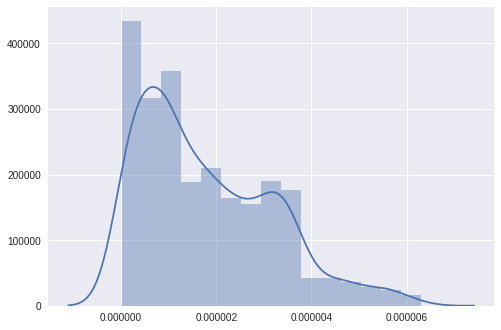

In [41]:


sns.distplot(list(map(np.exp2,(kde.score_samples(rentdata[:1000])))))